# レスラー方程式(外力のある状態)

レスラー方程式の外力のある場合に関して，$sin$波に位相のシフトがある場合を考える．

In [2]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


In [3]:
def phase_shift(t):
    # 2πは1日に対応します。8時間は(8/24)*2πに対応します。
    shift_value = (8/24)*2*np.pi
    # 4日ごとに位相をシフトします。
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value


In [4]:
def rossler_system_with_shifted_force(t, state, a, b, c, A):
    x, y, z = state
    dxdt = -y - z + A * np.sin(t + phase_shift(t))  # X項に外力P(t)を加える（位相シフト付き）
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]


In [5]:
# 外力P(t)の振幅Aをパラメータとして追加します。
A = 2.0  # 外力の振幅を設定します。この値を変更することで、外力の強さを変えられます。

# パラメータ
a = 0.2
b = 0.2
c = 5.7

# 初期条件
initial_state = [1.0, 1.0, 1.0]

# 時間の設定
t_span = [0, 2510]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 25100)  # 評価する時間点


In [6]:
# 微分方程式の数値解を求める
solution_with_shifted_force = solve_ivp(
    rossler_system_with_shifted_force, t_span, initial_state,
    args=(a, b, c, A), t_eval=t_eval, max_step=0.01
)

# 外力P(t)の計算（位相シフト付き）
P_shifted = A * np.sin(solution_with_shifted_force.t + np.array([phase_shift(ti) for ti in solution_with_shifted_force.t]))

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': solution_with_shifted_force.t,
    'x': solution_with_shifted_force.y[0],
    'y': solution_with_shifted_force.y[1],
    'z': solution_with_shifted_force.y[2],
    'P_shifted': P_shifted  # 位相シフトされた外力P(t)の列を追加
})


In [7]:
filename_with_force = 'rossler_data_with_shifted_forceA2.0.csv'

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)


# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values



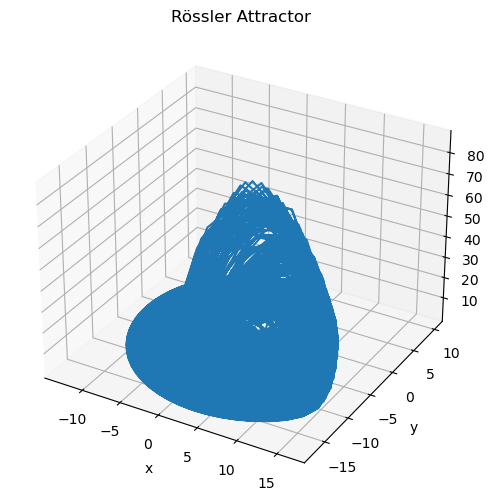

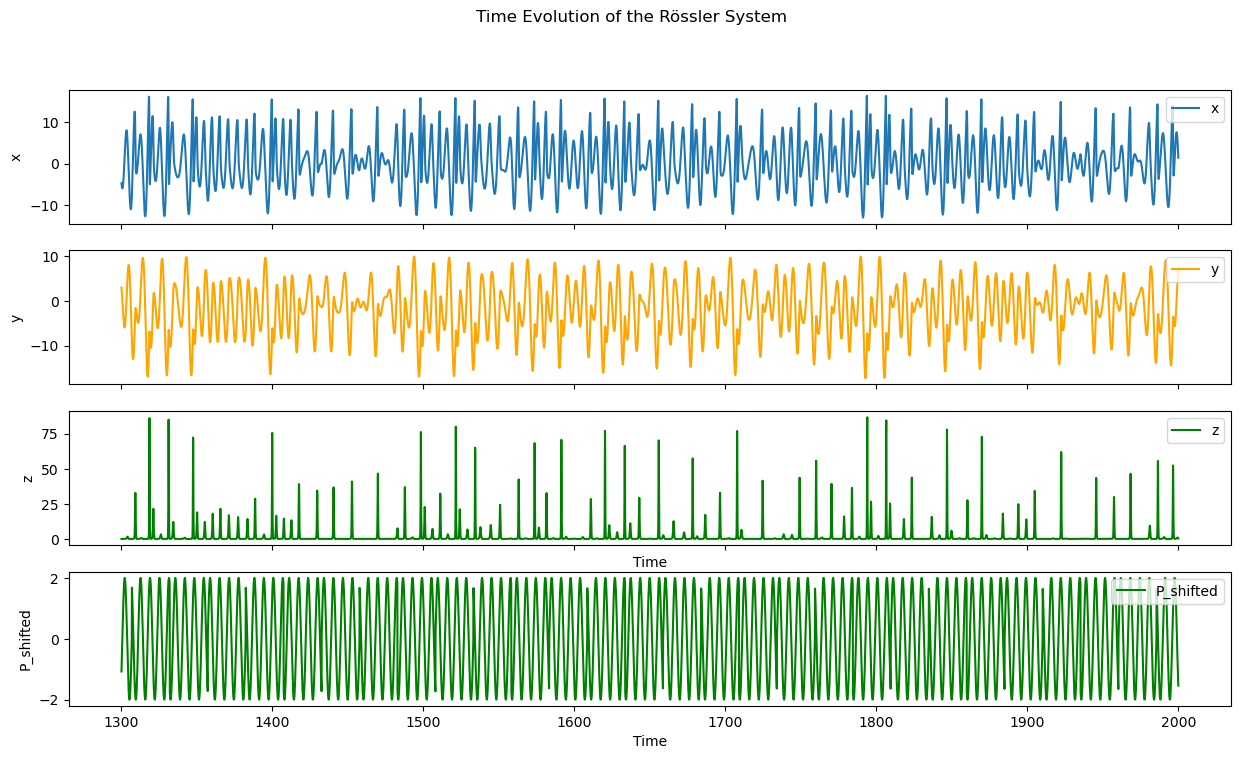

In [14]:
# XYZの三次元グラフをプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_frame_with_shifted_force['x'], data_frame_with_shifted_force['y'], data_frame_with_shifted_force['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler Attractor')
plt.show()

sample = 13000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['x'][sample: sample+7000], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['y'][sample: sample+7000], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['z'][sample: sample+7000], label='z', color='green')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

axs[3].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['P_shifted'][sample: sample+7000], label='P_shifted', color='green')
axs[3].set_ylabel('P_shifted')
axs[3].set_xlabel('Time')
axs[3].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


ここまで，正しくシミュレーションが出来た．

実際にESNを用いる際に扱うデータはXであるが，これはレスラー方程式のx, y項のみを含む二次元の配列である．

In [15]:
X.shape


(25100, 3)

### 2. hyperoptを用いたESNのパラメータの最適化

ESNを用いる際に決定しなければならないhyperparameterの初期値をhyperoptを用いて最適化する．

注．quniformの使い方に慣れていないが，ここでは自分で整数に丸めて使うことにする．

In [16]:
from hyperopt import hp, tpe, Trials, fmin


In [17]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    N_value = int(N)  # Nを整数に変換    

    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N_value, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        prediction = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, prediction, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, prediction)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}


In [18]:
hyperopt_config = {
    "exp": f"hyperopt-rossler_sin_shifted2.1.1", # the experimentation name
    "hp_max_evals": 300,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "tpe",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried oikiwith each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],  # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 5555]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [19]:
from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))


In [20]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")


  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

  4%|▎         | 11/300 [00:52<23:04,  4.79s/trial, best loss: 0.0030845116034237865]


KeyboardInterrupt: 

In [ ]:
# `best`タプルの最初の要素には最適化されたハイパーパラメータが直接含まれています
best_params = best[0]

# numpy int64型をPythonのint型に変換するための関数
def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

# 最適なハイパーパラメータをJSONファイルに保存
with open(f"{hyperopt_config['exp']}_best_params.json", 'w') as f:
    json.dump(best_params, f, default=convert)


In [ ]:
best


({'N': 4976.0,
  'iss': 0.08487429516603366,
  'lr': 0.6613014945020316,
  'ridge': 6.3862820679702745e-09,
  'seed': 0,
  'sr': 1.133073443655351},
 <hyperopt.base.Trials at 0x105caecd0>)

24時間かかるらしいので断念．とりあえず，Optuna+Neptune.aiを試そう．